In [138]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
import ast
from textblob import TextBlob
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

df_ted_main = pd.read_csv("data/ted_main.csv")
df_ted_transcripts = df = pd.read_csv("data/transcripts.csv")

In [112]:
############### PREPROCESSING OF THE DATA ###############
# - removing columns that are not needed
# - one hot encoding columns
# - adding sentiment analysis of transcripts 
# - combining columns together to create a new structure of the data frame

In [113]:
# ----------------------------------------------------------
# 1. remove unwanted columns
# ----------------------------------------------------------

df_ted_main.drop(['description', 'film_date', 'main_speaker', 'name', 'num_speaker', 'related_talks', 'speaker_occupation', 'title', 'url'], axis=1, inplace=True)
df_ted_main.head()

,comments,duration,event,languages,published_date,ratings,tags,views
0,4553,1164,TED2006,60,1151367060,"[{'id': 7, 'name': 'Funny', 'count': 19645}, {...","['children', 'creativity', 'culture', 'dance',...",47227110
1,265,977,TED2006,43,1151367060,"[{'id': 7, 'name': 'Funny', 'count': 544}, {'i...","['alternative energy', 'cars', 'climate change...",3200520
2,124,1286,TED2006,26,1151367060,"[{'id': 7, 'name': 'Funny', 'count': 964}, {'i...","['computers', 'entertainment', 'interface desi...",1636292
3,200,1116,TED2006,35,1151367060,"[{'id': 3, 'name': 'Courageous', 'count': 760}...","['MacArthur grant', 'activism', 'business', 'c...",1697550
4,593,1190,TED2006,48,1151440680,"[{'id': 9, 'name': 'Ingenious', 'count': 3202}...","['Africa', 'Asia', 'Google', 'demo', 'economic...",12005869


In [114]:
# ----------------------------------------------------------
# 2. one hot encoding
# ----------------------------------------------------------

# one hot encoding tags

# iterate trough the data set
for i, row in df_ted_main.iterrows():
    # change string formed list into normal list
    element_list_form = ast.literal_eval(df_ted_main.at[i,'tags'])
    element_list_form = [i.strip() for i in element_list_form]
    # finish converting by replacing string version of a list for the list type
    df_ted_main.at[i,'tags'] = element_list_form

# one hot encoding with column named "tags"
# since "tags" is a Series on each row, we need to split them first and then we can do one hot encoding
df_ted_main = df_ted_main.drop('tags', 1).join(
    pd.get_dummies(
        pd.DataFrame(df_ted_main.tags.tolist()).stack()
    ).astype(int).sum(level=0)
)

df_ted_main.head()

,comments,duration,event,languages,published_date,ratings,views,3d printing,AI,AIDS,...,wikipedia,wind energy,women,women in business,work,work-life balance,world cultures,writing,wunderkind,youth
0,4553,1164,TED2006,60,1151367060,"[{'id': 7, 'name': 'Funny', 'count': 19645}, {...",47227110,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,265,977,TED2006,43,1151367060,"[{'id': 7, 'name': 'Funny', 'count': 544}, {'i...",3200520,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,124,1286,TED2006,26,1151367060,"[{'id': 7, 'name': 'Funny', 'count': 964}, {'i...",1636292,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,200,1116,TED2006,35,1151367060,"[{'id': 3, 'name': 'Courageous', 'count': 760}...",1697550,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,593,1190,TED2006,48,1151440680,"[{'id': 9, 'name': 'Ingenious', 'count': 3202}...",12005869,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [115]:
# one hot encoding "event" column

def one_hot_encode(original_dataframe, feature_to_encode):
    dummies = pd.get_dummies(original_dataframe[[feature_to_encode]])
    res = pd.concat([original_dataframe, dummies], axis=1)
    res = res.drop([feature_to_encode], axis=1)
    return(res)

df_ted_main = one_hot_encode(df_ted_main, 'event')
df_ted_main.head()

,comments,duration,languages,published_date,ratings,views,3d printing,AI,AIDS,Addiction,...,event_TEDxZurich,event_TEDxZurich 2011,event_TEDxZurich 2012,event_TEDxZurich 2013,event_Taste3 2008,event_The Do Lectures,event_Toronto Youth Corps,event_University of California,event_Web 2.0 Expo 2008,event_World Science Festival
0,4553,1164,60,1151367060,"[{'id': 7, 'name': 'Funny', 'count': 19645}, {...",47227110,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,265,977,43,1151367060,"[{'id': 7, 'name': 'Funny', 'count': 544}, {'i...",3200520,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,124,1286,26,1151367060,"[{'id': 7, 'name': 'Funny', 'count': 964}, {'i...",1636292,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,200,1116,35,1151367060,"[{'id': 3, 'name': 'Courageous', 'count': 760}...",1697550,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,593,1190,48,1151440680,"[{'id': 9, 'name': 'Ingenious', 'count': 3202}...",12005869,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [116]:
#rating analysis

df_ted_main['ratings']=df_ted_main['ratings'].str.replace("'",'"')

df_ted_main=df_ted_main.merge(df_ted_main.ratings.apply(lambda x: pd.Series(pd.read_json(x)['count'].values,index=pd.read_json(x)['name'])), 
            left_index=True, right_index=True)

df_ted_main.drop('ratings', axis=1, inplace=True)

df_ted_main.head()

,comments,duration,languages,published_date,views,3d printing,AI,AIDS,Addiction,Africa,...,Longwinded,Confusing,Informative,Fascinating,Unconvincing,Persuasive,Jaw-dropping,OK,Obnoxious,Inspiring
0,4553,1164,60,1151367060,47227110,0,0,0,0,0,...,387,242,7346,10581,300,10704,4439,1174,209,24924
1,265,977,43,1151367060,3200520,0,0,0,0,0,...,113,62,443,132,258,268,116,203,131,413
2,124,1286,26,1151367060,1636292,0,0,0,0,0,...,78,27,395,166,104,230,54,146,142,230
3,200,1116,35,1151367060,1697550,0,0,0,0,0,...,53,32,380,132,36,460,230,85,35,1070
4,593,1190,48,1151440680,12005869,0,0,0,0,1,...,110,72,5433,4606,67,2542,3736,248,61,2893


In [117]:
# sentiment analysis of transcript
pol = lambda x: TextBlob(x).sentiment.polarity
sub = lambda x: TextBlob(x).sentiment.subjectivity

df_ted_transcripts['polarity'] = df_ted_transcripts['transcript'].apply(pol)
df_ted_transcripts['subjectivity'] = df_ted_transcripts['transcript'].apply(sub)
df_ted_transcripts

,transcript,url,polarity,subjectivity
0,Good morning. How are you?(Laughter)It's been ...,https://www.ted.com/talks/ken_robinson_says_sc...,0.146452,0.462051
1,"Thank you so much, Chris. And it's truly a gre...",https://www.ted.com/talks/al_gore_on_averting_...,0.157775,0.424101
2,"(Music: ""The Sound of Silence,"" Simon & Garfun...",https://www.ted.com/talks/david_pogue_says_sim...,0.136579,0.475229
3,If you're here today — and I'm very happy that...,https://www.ted.com/talks/majora_carter_s_tale...,0.082928,0.439165
4,"About 10 years ago, I took on the task to teac...",https://www.ted.com/talks/hans_rosling_shows_t...,0.096483,0.450631
...,...,...,...,...
2462,"So, Ma was trying to explain something to me a...",https://www.ted.com/talks/duarte_geraldino_wha...,0.038878,0.352668
2463,This is a picture of a sunset on Mars taken by...,https://www.ted.com/talks/armando_azua_bustos_...,0.127087,0.538377
2464,"In my early days as a graduate student, I went...",https://www.ted.com/talks/radhika_nagpal_what_...,0.193538,0.526466
2465,I took a cell phone and accidentally made myse...,https://www.ted.com/talks/theo_e_j_wilson_a_bl...,0.100929,0.498050


In [118]:
# merging both datasets and delete the rows that don't have a transcipt
result = pd.merge(df_ted_main, df_ted_transcripts, left_index=True, right_index=True)

In [119]:
result

,comments,duration,languages,published_date,views,3d printing,AI,AIDS,Addiction,Africa,...,Unconvincing,Persuasive,Jaw-dropping,OK,Obnoxious,Inspiring,transcript,url,polarity,subjectivity
0,4553,1164,60,1151367060,47227110,0,0,0,0,0,...,300,10704,4439,1174,209,24924,Good morning. How are you?(Laughter)It's been ...,https://www.ted.com/talks/ken_robinson_says_sc...,0.146452,0.462051
1,265,977,43,1151367060,3200520,0,0,0,0,0,...,258,268,116,203,131,413,"Thank you so much, Chris. And it's truly a gre...",https://www.ted.com/talks/al_gore_on_averting_...,0.157775,0.424101
2,124,1286,26,1151367060,1636292,0,0,0,0,0,...,104,230,54,146,142,230,"(Music: ""The Sound of Silence,"" Simon & Garfun...",https://www.ted.com/talks/david_pogue_says_sim...,0.136579,0.475229
3,200,1116,35,1151367060,1697550,0,0,0,0,0,...,36,460,230,85,35,1070,If you're here today — and I'm very happy that...,https://www.ted.com/talks/majora_carter_s_tale...,0.082928,0.439165
4,593,1190,48,1151440680,12005869,0,0,0,0,1,...,67,2542,3736,248,61,2893,"About 10 years ago, I took on the task to teac...",https://www.ted.com/talks/hans_rosling_shows_t...,0.096483,0.450631
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2462,35,920,20,1496156399,1079698,0,1,0,0,0,...,9,103,11,26,4,258,"So, Ma was trying to explain something to me a...",https://www.ted.com/talks/duarte_geraldino_wha...,0.038878,0.352668
2463,34,452,17,1496242092,957803,0,0,0,0,0,...,11,74,21,30,4,185,This is a picture of a sunset on Mars taken by...,https://www.ted.com/talks/armando_azua_bustos_...,0.127087,0.538377
2464,18,1230,14,1496327443,874817,0,0,0,0,1,...,0,55,10,22,3,196,"In my early days as a graduate student, I went...",https://www.ted.com/talks/radhika_nagpal_what_...,0.193538,0.526466
2465,10,885,8,1496400857,946815,0,0,0,0,0,...,0,9,24,0,9,63,I took a cell phone and accidentally made myse...,https://www.ted.com/talks/theo_e_j_wilson_a_bl...,0.100929,0.498050


In [120]:
# deleting the transcript and url columns because we don't need them.
del result['transcript']
del result['url']

In [121]:
result

,comments,duration,languages,published_date,views,3d printing,AI,AIDS,Addiction,Africa,...,Informative,Fascinating,Unconvincing,Persuasive,Jaw-dropping,OK,Obnoxious,Inspiring,polarity,subjectivity
0,4553,1164,60,1151367060,47227110,0,0,0,0,0,...,7346,10581,300,10704,4439,1174,209,24924,0.146452,0.462051
1,265,977,43,1151367060,3200520,0,0,0,0,0,...,443,132,258,268,116,203,131,413,0.157775,0.424101
2,124,1286,26,1151367060,1636292,0,0,0,0,0,...,395,166,104,230,54,146,142,230,0.136579,0.475229
3,200,1116,35,1151367060,1697550,0,0,0,0,0,...,380,132,36,460,230,85,35,1070,0.082928,0.439165
4,593,1190,48,1151440680,12005869,0,0,0,0,1,...,5433,4606,67,2542,3736,248,61,2893,0.096483,0.450631
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2462,35,920,20,1496156399,1079698,0,1,0,0,0,...,88,120,9,103,11,26,4,258,0.038878,0.352668
2463,34,452,17,1496242092,957803,0,0,0,0,0,...,50,22,11,74,21,30,4,185,0.127087,0.538377
2464,18,1230,14,1496327443,874817,0,0,0,0,1,...,49,38,0,55,10,22,3,196,0.193538,0.526466
2465,10,885,8,1496400857,946815,0,0,0,0,0,...,13,43,0,9,24,0,9,63,0.100929,0.498050


In [12]:
# Pandas describe() is used to view some basic statistical details like percentile, mean, std etc.
# of a data frame or a series of numeric values.
result.describe()

,comments,duration,languages,published_date,views,3d printing,AI,AIDS,Addiction,Africa,...,Informative,Fascinating,Unconvincing,Persuasive,Jaw-dropping,OK,Obnoxious,Inspiring,polarity,subjectivity
count,2467.000000,2467.000000,2467.000000,2.467000e+03,2.467000e+03,2467.000000,2467.000000,2467.000000,2467.000000,2467.000000,...,2467.000000,2467.000000,2467.000000,2467.000000,2467.000000,2467.000000,2467.000000,2467.000000,2467.000000,2467.000000
mean,197.134576,829.147548,27.957844,1.338192e+09,1.724277e+06,0.001216,0.014187,0.006486,0.001621,0.039724,...,356.396028,322.543575,54.271990,225.788002,152.490474,83.605999,26.760843,543.645724,0.123911,0.464265
std,285.333894,377.874229,8.999766,9.156275e+07,2.534605e+06,0.034858,0.118286,0.080288,0.040242,0.195350,...,546.919139,633.131476,92.807461,473.312491,562.578622,90.856939,54.164400,1333.838520,0.056033,0.058011
min,5.000000,135.000000,0.000000,1.151367e+09,5.044300e+04,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,-0.183942,0.000000
25%,68.000000,576.000000,23.000000,1.266321e+09,7.641575e+05,0.000000,0.000000,0.000000,0.000000,0.000000,...,105.000000,83.000000,12.000000,39.000000,19.000000,34.000000,6.000000,117.000000,0.090815,0.432490
50%,123.000000,854.000000,28.000000,1.337182e+09,1.136037e+06,0.000000,0.000000,0.000000,0.000000,0.000000,...,219.000000,168.000000,28.000000,100.000000,44.000000,58.000000,13.000000,241.000000,0.123564,0.464179
75%,226.000000,1054.000000,33.000000,1.414293e+09,1.727858e+06,0.000000,0.000000,0.000000,0.000000,0.000000,...,411.000000,354.500000,61.000000,233.500000,116.000000,101.000000,28.000000,508.000000,0.156340,0.496142
max,6404.000000,5256.000000,72.000000,1.496418e+09,4.722711e+07,1.000000,1.000000,1.000000,1.000000,1.000000,...,9787.000000,14447.000000,2194.000000,10704.000000,14728.000000,1341.000000,1361.000000,24924.000000,0.594444,0.777778


In [13]:
# ted_train, ted_test = train_test_split(result, test_size=0.20, random_state=42, shuffle = True)

In [14]:
# ted_train

In [15]:
# ted_test

In [16]:
# from sklearn.model_selection import StratifiedShuffleSplit

# split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
# for train_index, test_index in split.split(result, result["views"]):
#     strat_train_set = result.loc[train_index]
#     strat_test_set = result.loc[test_index]

In [17]:
# strat_test_set["views"].value_counts() / len(strat_test_set)

In [18]:
# std stands for Standard deviation. The Standard Deviation is a measure of how spread out numbers are.

In [19]:
# # # Standardization
# scaler_stand = StandardScaler() 
# data_scaled_stand = scaler_stand.fit_transform(result)
# result.loc[:,:] = data_scaled_stand

In [122]:
result

,comments,duration,languages,published_date,views,3d printing,AI,AIDS,Addiction,Africa,...,Informative,Fascinating,Unconvincing,Persuasive,Jaw-dropping,OK,Obnoxious,Inspiring,polarity,subjectivity
0,4553,1164,60,1151367060,47227110,0,0,0,0,0,...,7346,10581,300,10704,4439,1174,209,24924,0.146452,0.462051
1,265,977,43,1151367060,3200520,0,0,0,0,0,...,443,132,258,268,116,203,131,413,0.157775,0.424101
2,124,1286,26,1151367060,1636292,0,0,0,0,0,...,395,166,104,230,54,146,142,230,0.136579,0.475229
3,200,1116,35,1151367060,1697550,0,0,0,0,0,...,380,132,36,460,230,85,35,1070,0.082928,0.439165
4,593,1190,48,1151440680,12005869,0,0,0,0,1,...,5433,4606,67,2542,3736,248,61,2893,0.096483,0.450631
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2462,35,920,20,1496156399,1079698,0,1,0,0,0,...,88,120,9,103,11,26,4,258,0.038878,0.352668
2463,34,452,17,1496242092,957803,0,0,0,0,0,...,50,22,11,74,21,30,4,185,0.127087,0.538377
2464,18,1230,14,1496327443,874817,0,0,0,0,1,...,49,38,0,55,10,22,3,196,0.193538,0.526466
2465,10,885,8,1496400857,946815,0,0,0,0,0,...,13,43,0,9,24,0,9,63,0.100929,0.498050


In [21]:
# # print the mean of the scaled data.
# print(data_scaled_stand.mean(axis=0))

In [22]:
# # print the std of the scaled data
# print(data_scaled_stand.std(axis=0))

In [23]:
# # print the min value
# print(data_scaled_stand.min(axis=0))

In [24]:
# # print the max value
# print(data_scaled_stand.max(axis=0))

In [25]:
# # Normalization
# scaler_norm = MinMaxScaler() 
# data_scaled_norm = scaler_norm.fit_transform(result)

In [26]:
# # print mean
# print(data_scaled_norm.mean(axis=0))

In [27]:
# # print std
# print(data_scaled_norm.std(axis=0))

In [28]:
# data_scaled_norm

In [123]:
# Labels are the values we want to predict
labels = np.array(result['views'])

In [124]:
# Remove the labels from the features
# axis 1 refers to the columns
result = result.drop('views', axis = 1)

In [125]:
result

,comments,duration,languages,published_date,3d printing,AI,AIDS,Addiction,Africa,Alzheimer's,...,Informative,Fascinating,Unconvincing,Persuasive,Jaw-dropping,OK,Obnoxious,Inspiring,polarity,subjectivity
0,4553,1164,60,1151367060,0,0,0,0,0,0,...,7346,10581,300,10704,4439,1174,209,24924,0.146452,0.462051
1,265,977,43,1151367060,0,0,0,0,0,0,...,443,132,258,268,116,203,131,413,0.157775,0.424101
2,124,1286,26,1151367060,0,0,0,0,0,0,...,395,166,104,230,54,146,142,230,0.136579,0.475229
3,200,1116,35,1151367060,0,0,0,0,0,0,...,380,132,36,460,230,85,35,1070,0.082928,0.439165
4,593,1190,48,1151440680,0,0,0,0,1,0,...,5433,4606,67,2542,3736,248,61,2893,0.096483,0.450631
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2462,35,920,20,1496156399,0,1,0,0,0,0,...,88,120,9,103,11,26,4,258,0.038878,0.352668
2463,34,452,17,1496242092,0,0,0,0,0,0,...,50,22,11,74,21,30,4,185,0.127087,0.538377
2464,18,1230,14,1496327443,0,0,0,0,1,0,...,49,38,0,55,10,22,3,196,0.193538,0.526466
2465,10,885,8,1496400857,0,0,0,0,0,0,...,13,43,0,9,24,0,9,63,0.100929,0.498050


In [126]:
# Saving result names for later use
result_list = list(result.columns)

In [33]:
# Convert to numpy array
# result = np.array(result)

In [34]:
result

array([[4.55300000e+03, 1.16400000e+03, 6.00000000e+01, ...,
        2.49240000e+04, 1.46451561e-01, 4.62051257e-01],
       [2.65000000e+02, 9.77000000e+02, 4.30000000e+01, ...,
        4.13000000e+02, 1.57774636e-01, 4.24101278e-01],
       [1.24000000e+02, 1.28600000e+03, 2.60000000e+01, ...,
        2.30000000e+02, 1.36578712e-01, 4.75229322e-01],
       ...,
       [1.80000000e+01, 1.23000000e+03, 1.40000000e+01, ...,
        1.96000000e+02, 1.93538275e-01, 5.26465612e-01],
       [1.00000000e+01, 8.85000000e+02, 8.00000000e+00, ...,
        6.30000000e+01, 1.00929182e-01, 4.98050241e-01],
       [2.00000000e+01, 7.46000000e+02, 1.60000000e+01, ...,
        1.74000000e+02, 6.81427679e-02, 4.08302093e-01]])

In [127]:
# Split the data into training and testing sets
train_set, test_set, train_labels, test_labels = train_test_split(result, labels, test_size = 0.25, random_state = 42)

In [129]:
result

,comments,duration,languages,published_date,3d printing,AI,AIDS,Addiction,Africa,Alzheimer's,...,Informative,Fascinating,Unconvincing,Persuasive,Jaw-dropping,OK,Obnoxious,Inspiring,polarity,subjectivity
0,4553,1164,60,1151367060,0,0,0,0,0,0,...,7346,10581,300,10704,4439,1174,209,24924,0.146452,0.462051
1,265,977,43,1151367060,0,0,0,0,0,0,...,443,132,258,268,116,203,131,413,0.157775,0.424101
2,124,1286,26,1151367060,0,0,0,0,0,0,...,395,166,104,230,54,146,142,230,0.136579,0.475229
3,200,1116,35,1151367060,0,0,0,0,0,0,...,380,132,36,460,230,85,35,1070,0.082928,0.439165
4,593,1190,48,1151440680,0,0,0,0,1,0,...,5433,4606,67,2542,3736,248,61,2893,0.096483,0.450631
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2462,35,920,20,1496156399,0,1,0,0,0,0,...,88,120,9,103,11,26,4,258,0.038878,0.352668
2463,34,452,17,1496242092,0,0,0,0,0,0,...,50,22,11,74,21,30,4,185,0.127087,0.538377
2464,18,1230,14,1496327443,0,0,0,0,1,0,...,49,38,0,55,10,22,3,196,0.193538,0.526466
2465,10,885,8,1496400857,0,0,0,0,0,0,...,13,43,0,9,24,0,9,63,0.100929,0.498050


In [128]:
print('Training result Shape:', train_set.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing result Shape:', test_set.shape)
print('Testing Labels Shape:', test_labels.shape)

Training result Shape: (1850, 791)
Training Labels Shape: (1850,)
Testing result Shape: (617, 791)
Testing Labels Shape: (617,)


In [130]:
scaler_stand = StandardScaler() 
data_scaled_stand = scaler_stand.fit_transform(train_set)

In [131]:
scaler_stand = StandardScaler() 
data_scaled_stand = scaler_stand.fit_transform(test_set)

In [141]:
rf = RandomForestRegressor(criterion='mae',max_depth=15, max_features=45, n_estimators=100, min_samples_leaf=2, min_samples_split=2,
                           random_state=42)
rf.fit(train_set, train_labels)
pred_labels = rf.predict(train_set)
test_pred_labels = rf.predict(test_set)

errors = abs(test_pred_labels - test_labels)

print('Training MAE: {:0.2f}'.format(metrics.mean_absolute_error(train_labels, pred_labels)))
print('Test MAE: {:0.2f}'.format(metrics.mean_absolute_error(test_labels, test_pred_labels)), 'degrees')
print('Views mean: {:0.2f}'.format(labels.mean()))
print('Views std: {:0.2f}'.format(labels.std()))

# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / test_labels)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Training MAE: 375182.88
Test MAE: 517257.40 degrees
Views mean: 1724277.02
Views std: 2534090.78
Accuracy: 59.57 %.


In [142]:
# # Instantiate model with n decision trees
# rf = RandomForestRegressor(n_estimators = 100, random_state = 42)

# # Train the model on training data
# rf.fit(train_set, train_labels);

In [143]:
# # Use the forest's predict method on the test data
# predictions = rf.predict(test_set)

# # Calculate the absolute errors
# errors = abs(predictions - test_labels)

# # Print out the mean absolute error (mae)
# print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

Mean Absolute Error: 472935.55 degrees.


In [144]:
# # Calculate mean absolute percentage error (MAPE)
# mape = 100 * (errors / test_labels)
# # Calculate and display accuracy
# accuracy = 100 - np.mean(mape)
# print('Accuracy:', round(accuracy, 2), '%.')

Accuracy: 69.32 %.


In [133]:
# Import tools needed for visualization
from sklearn.tree import export_graphviz
import pydot

# Pull out one tree from the forest
tree = rf.estimators_[5]

# Export the image to a dot file
export_graphviz(tree, out_file = 'tree.dot', feature_names = result_list, rounded = True, precision = 1)

# Use dot file to create a graph
(graph, ) = pydot.graph_from_dot_file('tree.dot')

# Write graph to a png file
graph.write_png('tree.png')

In [134]:
# Limit depth of tree to 3 levels
rf_small = RandomForestRegressor(n_estimators=10, max_depth = 3)
rf_small.fit(train_set, train_labels)
# Extract the small tree
tree_small = rf_small.estimators_[5]
# Save the tree as a png image
export_graphviz(tree_small, out_file = 'small_tree.dot', feature_names = result_list, rounded = True, precision = 1)
(graph, ) = pydot.graph_from_dot_file('small_tree.dot')
graph.write_png('small_tree.png');

In [ ]:
# I plot the feature importances that are derived from the model that was just trained.
# We can use this in the future to exclude the unimportant features with the hope of boosting performance.

In [145]:

train_set

,comments,duration,languages,published_date,3d printing,AI,AIDS,Addiction,Africa,Alzheimer's,...,Informative,Fascinating,Unconvincing,Persuasive,Jaw-dropping,OK,Obnoxious,Inspiring,polarity,subjectivity
99,42,858,23,1177632660,0,0,0,0,0,0,...,334,100,17,51,15,85,12,55,-0.022980,0.217845
1357,92,985,19,1350399604,0,0,0,0,0,0,...,113,38,8,181,18,14,2,122,0.214735,0.480775
2081,44,691,35,1446824200,0,0,0,0,0,0,...,9,147,36,3,44,81,13,143,0.083652,0.424854
1204,124,394,28,1334329344,0,0,0,0,0,0,...,16,85,6,67,65,46,7,406,0.111461,0.432171
529,248,999,25,1254790800,0,0,0,0,0,0,...,396,333,128,341,64,134,45,597,0.139217,0.430342
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1638,253,857,29,1386345659,0,0,0,0,0,0,...,202,135,58,302,30,31,14,396,0.140252,0.546139
1095,363,1122,32,1324310558,0,0,0,0,0,0,...,740,605,89,180,68,120,22,201,0.126225,0.437179
1130,63,683,27,1328200107,0,0,0,0,0,0,...,105,42,15,44,10,27,3,83,0.069553,0.470473
1294,67,848,21,1342969159,0,0,0,0,0,0,...,55,83,8,33,43,7,0,158,0.119079,0.285212


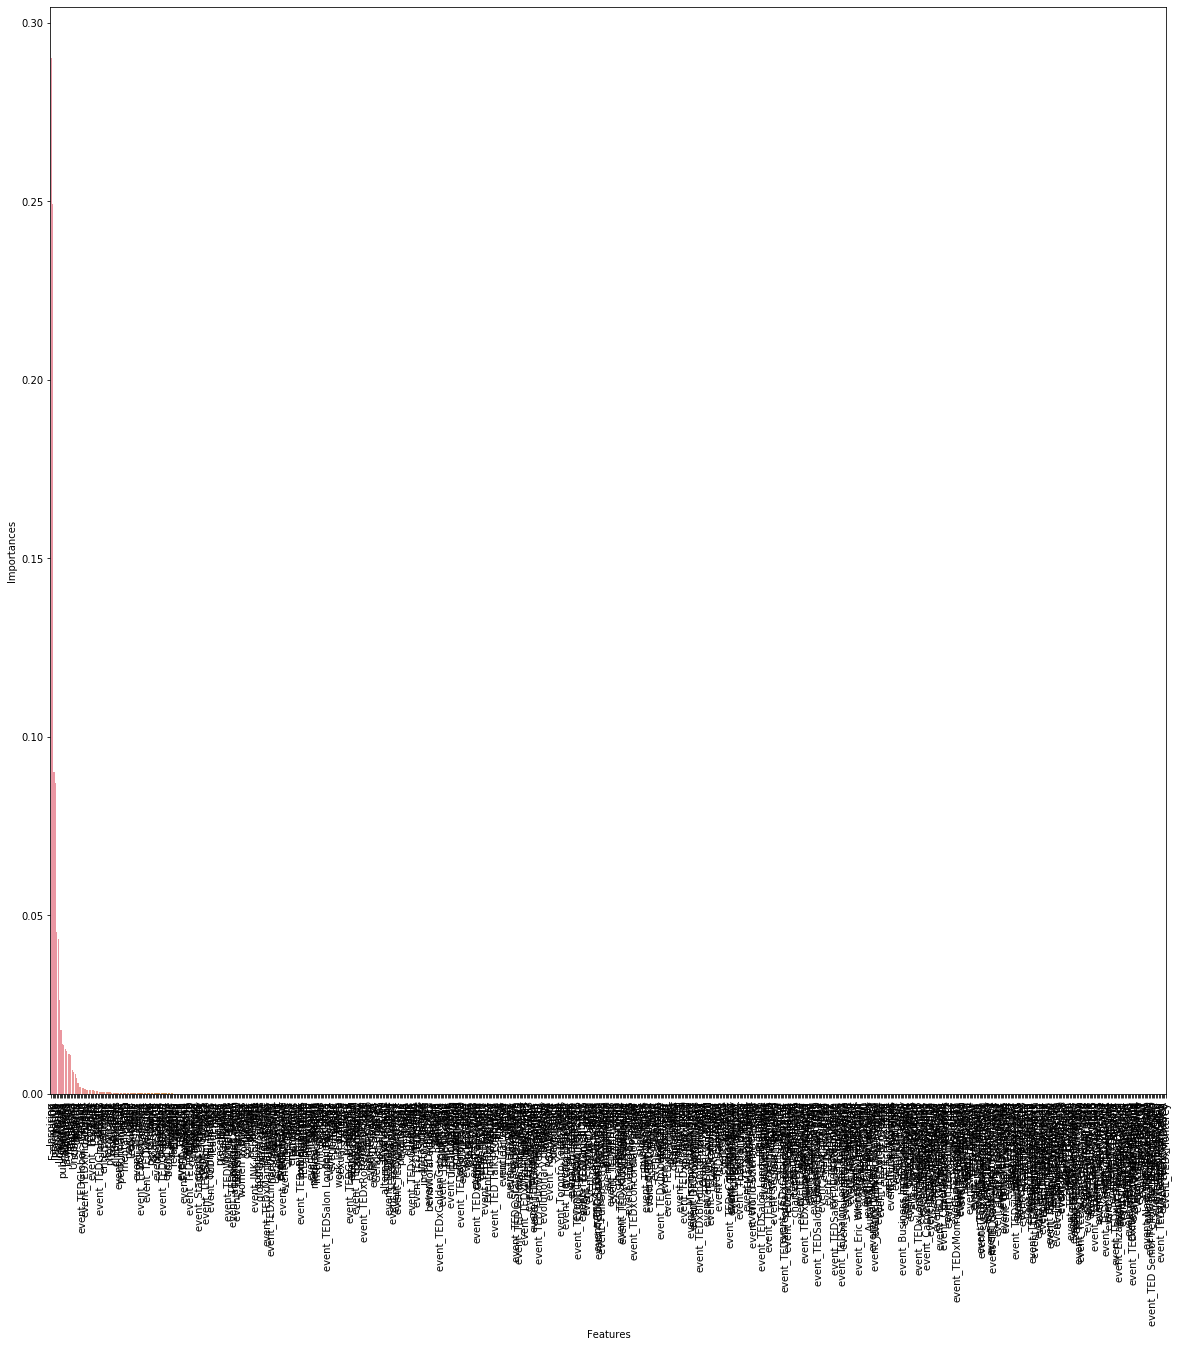

In [146]:
importances = pd.DataFrame({'Features': train_set.columns, 
                                'Importances': rf.feature_importances_})
    
importances.sort_values(by=['Importances'], axis='index', ascending=False, inplace=True)
fig = plt.figure(figsize=(20, 20))
sns.barplot(x='Features', y='Importances', data=importances)
plt.xticks(rotation='vertical')
plt.show()

In [147]:
importances

,Features,Importances
788,Inspiring,0.289945
782,Fascinating,0.249083
786,OK,0.090238
781,Informative,0.087151
784,Persuasive,0.045311
...,...,...
724,event_TEDxSeoul,0.000000
678,event_TEDxNASA@SiliconValley,0.000000
719,event_TEDxSanJoseCA,0.000000
715,event_TEDxSFU,0.000000
